In [0]:
import scipy.io as sio
import numpy as np
import os, gc, codecs, hashlib
import six.moves.urllib as urllib
import cv2, time, traceback, os, torch
import xml.etree.cElementTree as ET
import random, zipfile, csv, json
import shutil as sh
import random, io, sys, marshal, math, time
import pandas as pd
from shutil import copyfile
from glob import glob
from matplotlib import pyplot as plt
from xml.parsers import expat
from xml.sax.saxutils import XMLGenerator
from xml.sax.xmlreader import AttributesImpl
from io import StringIO
from PIL import Image
from collections import namedtuple, OrderedDict
from itertools import product as product

## Downloading Egohands

In [0]:
def save_csv(csv_path, csv_content):
    with open(csv_path, 'w') as csvfile:
        wr = csv.writer(csvfile)
        for i in range(len(csv_content)):
            wr.writerow(csv_content[i])

In [0]:
def get_bbox_visualize(base_path, dir):
    image_path_array = []
    for root, dirs, filenames in os.walk(base_path + dir):
        for f in filenames:
            if(f.split(".")[1] == "jpg"):
                img_path = base_path + dir + "/" + f
                image_path_array.append(img_path)

    #sort image_path_array to ensure its in the low to high order expected in polygon.mat
    image_path_array.sort()
    boxes = sio.loadmat(base_path + dir + "/polygons.mat")
    # there are 100 of these per folder in the egohands dataset
    polygons = boxes["polygons"][0]
    # first = polygons[0]
    # print(len(first))
    pointindex = 0

    for first in polygons:
        index = 0

        font = cv2.FONT_HERSHEY_SIMPLEX

        img_id = image_path_array[pointindex]
        img = cv2.imread(img_id)

        img_params = {}
        img_params["width"] = np.size(img, 1)
        img_params["height"] = np.size(img, 0)
        head, tail = os.path.split(img_id)
        img_params["filename"] = tail
        img_params["path"] = os.path.abspath(img_id)
        img_params["type"] = "train"
        pointindex += 1

        boxarray = []
        csvholder = []
        for pointlist in first:
            pst = np.empty((0, 2), int)
            max_x = max_y = min_x = min_y = height = width = 0

            findex = 0
            for point in pointlist:
                if(len(point) == 2):
                    x = int(point[0])
                    y = int(point[1])

                    if(findex == 0):
                        min_x = x
                        min_y = y
                    findex += 1
                    max_x = x if (x > max_x) else max_x
                    min_x = x if (x < min_x) else min_x
                    max_y = y if (y > max_y) else max_y
                    min_y = y if (y < min_y) else min_y
                    # print(index, "====", len(point))
                    appeno = np.array([[x, y]])
                    pst = np.append(pst, appeno, axis=0)
                    cv2.putText(img, ".", (x, y), font, 0.7,
                                (255, 255, 255), 2, cv2.LINE_AA)

            hold = {}
            hold['minx'] = min_x
            hold['miny'] = min_y
            hold['maxx'] = max_x
            hold['maxy'] = max_y
            if (min_x > 0 and min_y > 0 and max_x > 0 and max_y > 0):
                boxarray.append(hold)
                labelrow = [tail,
                            np.size(img, 1), np.size(img, 0), "hand", min_x, min_y, max_x, max_y]
                csvholder.append(labelrow)

            cv2.polylines(img, [pst], True, (0, 255, 255), 1)
            cv2.rectangle(img, (min_x, max_y),
                          (max_x, min_y), (0, 255, 0), 1)

        csv_path = img_id.split(".")[0]
        if not os.path.exists(csv_path + ".csv"):
            cv2.putText(img, "DIR : " + dir + " - " + tail, (20, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.75, (77, 255, 9), 2)
            # cv2.imshow('Verifying annotation ', img)
            save_csv(csv_path + ".csv", csvholder)
            print("===== saving csv file for ", tail)
        # cv2.waitKey(2)

In [0]:
def create_directory(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [0]:
def generate_label_files(image_dir):
    header = ['filename', 'width', 'height',
              'class', 'xmin', 'ymin', 'xmax', 'ymax']
    for root, dirs, filenames in os.walk(image_dir):
        for dir in dirs:
            csvholder = []
            csvholder.append(header)
            loop_index = 0
            for f in os.listdir(image_dir + dir):
                if(f.split(".")[1] == "csv"):
                    loop_index += 1
                    #print(loop_index, f)
                    csv_file = open(image_dir + dir + "/" + f, 'r')
                    reader = csv.reader(csv_file)
                    for row in reader:
                        csvholder.append(row)
                    csv_file.close()
                    os.remove(image_dir + dir + "/" + f)
            save_csv(image_dir + dir + "/" + dir + "_labels.csv", csvholder)
            print("Saved label csv for ", dir, image_dir +
                  dir + "/" + dir + "_labels.csv")

In [0]:
def split_data_test_eval_train(image_dir):
    create_directory("images")
    create_directory("images/train")
    create_directory("images/test")

    data_size = 4000
    loop_index = 0
    data_sampsize = int(0.1 * data_size)
    test_samp_array = random.sample(range(data_size), k=data_sampsize)

    for root, dirs, filenames in os.walk(image_dir):
        for dir in dirs:
            for f in os.listdir(image_dir + dir):
                if(f.split(".")[1] == "jpg"):
                    loop_index += 1
                    print(loop_index, f)

                    if loop_index in test_samp_array:
                        os.rename(image_dir + dir +
                                  "/" + f, "images/test/" + f)
                        os.rename(image_dir + dir +
                                  "/" + f.split(".")[0] + ".csv", "images/test/" + f.split(".")[0] + ".csv")
                    else:
                        os.rename(image_dir + dir +
                                  "/" + f, "images/train/" + f)
                        os.rename(image_dir + dir +
                                  "/" + f.split(".")[0] + ".csv", "images/train/" + f.split(".")[0] + ".csv")
                    print(loop_index, image_dir + f)
            print(">   done scanning director ", dir)
            os.remove(image_dir + dir + "/polygons.mat")
            os.rmdir(image_dir + dir)

        print("Train/test content generation complete!")
        generate_label_files("images/")

In [0]:
def generate_csv_files(image_dir):
    for root, dirs, filenames in os.walk(image_dir):
        for dir in dirs:
            get_bbox_visualize(image_dir, dir)

    print("CSV generation complete!\nGenerating train/test/eval folders")
    split_data_test_eval_train("egohands/_LABELLED_SAMPLES/")

In [0]:
def rename_files(image_dir):
    print("Renaming files")
    loop_index = 0
    for root, dirs, filenames in os.walk(image_dir):
        for dir in dirs:
            for f in os.listdir(image_dir + dir):
                if (dir not in f):
                    if(f.split(".")[1] == "jpg"):
                        loop_index += 1
                        os.rename(image_dir + dir + "/" + f, image_dir + dir + "/" + dir + "_" + f)
                else:
                    break
    generate_csv_files("egohands/_LABELLED_SAMPLES/")

In [0]:
def extract_folder(dataset_path):
    print("Egohands dataset already downloaded.\nGenerating CSV files")
    if not os.path.exists("egohands"):
        zip_ref = zipfile.ZipFile(dataset_path, 'r')
        print("> Extracting Dataset files")
        zip_ref.extractall("egohands")
        print("> Extraction complete")
        zip_ref.close()
        rename_files("egohands/_LABELLED_SAMPLES/")

In [0]:
def download_egohands_dataset(dataset_url, dataset_path):
    is_downloaded = os.path.exists(dataset_path)
    if not is_downloaded:
        print(
            "> downloading egohands dataset. This may take a while (1.3GB, say 3-5mins). Coffee break?")
        opener = urllib.request.URLopener()
        opener.retrieve(dataset_url, dataset_path)
        print("> download complete")
        extract_folder(dataset_path);
    else:
        extract_folder(dataset_path)

In [11]:
download_egohands_dataset("http://vision.soic.indiana.edu/egohands_files/egohands_data.zip", "egohands_data.zip")

> downloading egohands dataset. This may take a while (1.3GB, say 3-5mins). Coffee break?


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  """Entry point for launching an IPython kernel.


> download complete
Egohands dataset already downloaded.
Generating CSV files
> Extracting Dataset files
> Extraction complete
Renaming files
===== saving csv file for  CHESS_OFFICE_H_T_frame_0040.jpg
===== saving csv file for  CHESS_OFFICE_H_T_frame_0073.jpg
===== saving csv file for  CHESS_OFFICE_H_T_frame_0099.jpg
===== saving csv file for  CHESS_OFFICE_H_T_frame_0121.jpg
===== saving csv file for  CHESS_OFFICE_H_T_frame_0132.jpg
===== saving csv file for  CHESS_OFFICE_H_T_frame_0133.jpg
===== saving csv file for  CHESS_OFFICE_H_T_frame_0142.jpg
===== saving csv file for  CHESS_OFFICE_H_T_frame_0199.jpg
===== saving csv file for  CHESS_OFFICE_H_T_frame_0207.jpg
===== saving csv file for  CHESS_OFFICE_H_T_frame_0283.jpg
===== saving csv file for  CHESS_OFFICE_H_T_frame_0299.jpg
===== saving csv file for  CHESS_OFFICE_H_T_frame_0325.jpg
===== saving csv file for  CHESS_OFFICE_H_T_frame_0348.jpg
===== saving csv file for  CHESS_OFFICE_H_T_frame_0445.jpg
===== saving csv file for  CHESS

In [0]:
!mkdir -p data/Hand/images
!mv images/train/*.jpg data/Hand/images
!mv images/test/*.jpg data/Hand/images

In [0]:
class ParsingInterrupted(Exception):
    pass

In [0]:
class _DictSAXHandler(object):
    def __init__(self, item_depth = 0,
                 item_callback = lambda *args: True,
                 xml_attribs = True, attr_prefix = '@',
                 cdata_key =' #text', force_cdata = False,
                 cdata_separator = '', postprocessor = None,
                 dict_constructor = OrderedDict,
                 strip_whitespace = True, namespace_separator = ':',
                 namespaces=None, force_list = None):
        self.path = []
        self.stack = []
        self.data = []
        self.item = None
        self.item_depth = item_depth
        self.xml_attribs = xml_attribs
        self.item_callback = item_callback
        self.attr_prefix = attr_prefix
        self.cdata_key = cdata_key
        self.force_cdata = force_cdata
        self.cdata_separator = cdata_separator
        self.postprocessor = postprocessor
        self.dict_constructor = dict_constructor
        self.strip_whitespace = strip_whitespace
        self.namespace_separator = namespace_separator
        self.namespaces = namespaces
        self.namespace_declarations = OrderedDict()
        self.force_list = force_list

    def _build_name(self, full_name):
        if not self.namespaces:
            return full_name
        i = full_name.rfind(self.namespace_separator)
        if i == -1:
            return full_name
        namespace, name = full_name[:i], full_name[i+1:]
        short_namespace = self.namespaces.get(namespace, namespace)
        if not short_namespace:
            return name
        else:
            return self.namespace_separator.join((short_namespace, name))

    def _attrs_to_dict(self, attrs):
        if isinstance(attrs, dict):
            return attrs
        return self.dict_constructor(zip(attrs[0::2], attrs[1::2]))

    def startNamespaceDecl(self, prefix, uri):
        self.namespace_declarations[prefix or ''] = uri

    def startElement(self, full_name, attrs):
        name = self._build_name(full_name)
        attrs = self._attrs_to_dict(attrs)
        if attrs and self.namespace_declarations:
            attrs['xmlns'] = self.namespace_declarations
            self.namespace_declarations = OrderedDict()
        self.path.append((name, attrs or None))
        if len(self.path) > self.item_depth:
            self.stack.append((self.item, self.data))
            if self.xml_attribs:
                attr_entries = []
                for key, value in attrs.items():
                    key = self.attr_prefix+self._build_name(key)
                    if self.postprocessor:
                        entry = self.postprocessor(self.path, key, value)
                    else:
                        entry = (key, value)
                    if entry:
                        attr_entries.append(entry)
                attrs = self.dict_constructor(attr_entries)
            else:
                attrs = None
            self.item = attrs or None
            self.data = []

    def endElement(self, full_name):
        name = self._build_name(full_name)
        if len(self.path) == self.item_depth:
            item = self.item
            if item is None:
                item = (None if not self.data
                        else self.cdata_separator.join(self.data))

            should_continue = self.item_callback(self.path, item)
            if not should_continue:
                raise ParsingInterrupted()
        if len(self.stack):
            data = (None if not self.data
                    else self.cdata_separator.join(self.data))
            item = self.item
            self.item, self.data = self.stack.pop()
            if self.strip_whitespace and data:
                data = data.strip() or None
            if data and self.force_cdata and item is None:
                item = self.dict_constructor()
            if item is not None:
                if data:
                    self.push_data(item, self.cdata_key, data)
                self.item = self.push_data(self.item, name, item)
            else:
                self.item = self.push_data(self.item, name, data)
        else:
            self.item = None
            self.data = []
        self.path.pop()

    def characters(self, data):
        if not self.data:
            self.data = [data]
        else:
            self.data.append(data)

    def push_data(self, item, key, data):
        if self.postprocessor is not None:
            result = self.postprocessor(self.path, key, data)
            if result is None:
                return item
            key, data = result
        if item is None:
            item = self.dict_constructor()
        try:
            value = item[key]
            if isinstance(value, list):
                value.append(data)
            else:
                item[key] = [value, data]
        except KeyError:
            if self._should_force_list(key, data):
                item[key] = [data]
            else:
                item[key] = data
        return item

    def _should_force_list(self, key, value):
        if not self.force_list:
            return False
        try:
            return key in self.force_list
        except TypeError:
            return self.force_list(self.path[:-1], key, value)

In [0]:
def parse(xml_input, encoding=None, expat=expat, process_namespaces=False, namespace_separator=':', disable_entities=True, **kwargs):
    handler = _DictSAXHandler(namespace_separator=namespace_separator, **kwargs)
    if isinstance(xml_input, str):
        if not encoding:
            encoding = 'utf-8'
        xml_input = xml_input.encode(encoding)
    if not process_namespaces:
        namespace_separator = None
    parser = expat.ParserCreate(
        encoding,
        namespace_separator
    )
    try:
        parser.ordered_attributes = True
    except AttributeError:
        pass
    parser.StartNamespaceDeclHandler = handler.startNamespaceDecl
    parser.StartElementHandler = handler.startElement
    parser.EndElementHandler = handler.endElement
    parser.CharacterDataHandler = handler.characters
    parser.buffer_text = True
    if disable_entities:
        try:
            feature = "http://apache.org/xml/features/disallow-doctype-decl"
            parser._reader.setFeature(feature, True)
        except AttributeError:
            parser.DefaultHandler = lambda x: None
            parser.ExternalEntityRefHandler = lambda *x: 1
    if hasattr(xml_input, 'read'):
        parser.ParseFile(xml_input)
    else:
        parser.Parse(xml_input, True)
    return handler.item

In [0]:
def _process_namespace(name, namespaces, ns_sep=':', attr_prefix='@'):
    if not namespaces:
        return name
    try:
        ns, name = name.rsplit(ns_sep, 1)
    except ValueError:
        pass
    else:
        ns_res = namespaces.get(ns.strip(attr_prefix))
        name = '{0}{1}{2}{3}'.format(
            attr_prefix if ns.startswith(attr_prefix) else '',
            ns_res, ns_sep, name) if ns_res else name
    return name

In [0]:
def _emit(key, value, content_handler,
          attr_prefix='@', cdata_key='#text',
          depth=0, preprocessor=None,
          pretty=False, newl='\n', indent='\t',
          namespace_separator=':',
          namespaces = None, full_document = True):
    key = _process_namespace(key, namespaces, namespace_separator, attr_prefix)
    if preprocessor is not None:
        result = preprocessor(key, value)
        if result is None:
            return
        key, value = result
    if (not hasattr(value, '__iter__')
            or isinstance(value, str)
            or isinstance(value, dict)):
        value = [value]
    for index, v in enumerate(value):
        if full_document and depth == 0 and index > 0:
            raise ValueError('document with multiple roots')
        if v is None:
            v = OrderedDict()
        elif not isinstance(v, dict):
            v = str(v)
        if isinstance(v, str):
            v = OrderedDict(((cdata_key, v),))
        cdata = None
        attrs = OrderedDict()
        children = []
        for ik, iv in v.items():
            if ik == cdata_key:
                cdata = iv
                continue
            if ik.startswith(attr_prefix):
                ik = _process_namespace(ik, namespaces, namespace_separator,
                                        attr_prefix)
                if ik == '@xmlns' and isinstance(iv, dict):
                    for k, v in iv.items():
                        attr = 'xmlns{0}'.format(':{0}'.format(k) if k else '')
                        attrs[attr] = str(v)
                    continue
                if not isinstance(iv, str):
                    iv = str(iv)
                attrs[ik[len(attr_prefix):]] = iv
                continue
            children.append((ik, iv))
        if pretty:
            content_handler.ignorableWhitespace(depth * indent)
        content_handler.startElement(key, AttributesImpl(attrs))
        if pretty and children:
            content_handler.ignorableWhitespace(newl)
        for child_key, child_value in children:
            _emit(child_key, child_value, content_handler,
                  attr_prefix, cdata_key, depth+1, preprocessor,
                  pretty, newl, indent, namespaces=namespaces,
                  namespace_separator=namespace_separator)
        if cdata is not None:
            content_handler.characters(cdata)
        if pretty and children:
            content_handler.ignorableWhitespace(depth * indent)
        content_handler.endElement(key)
        if pretty and depth:
            content_handler.ignorableWhitespace(newl)

In [0]:
def unparse(input_dict, output=None, encoding='utf-8', full_document=True, short_empty_elements=False, **kwargs):
    if full_document and len(input_dict) != 1:
        raise ValueError('Document must have exactly one root.')
    must_return = False
    if output is None:
        output = StringIO()
        must_return = True
    if short_empty_elements:
        content_handler = XMLGenerator(output, encoding, True)
    else:
        content_handler = XMLGenerator(output, encoding)
    if full_document:
        content_handler.startDocument()
    for key, value in input_dict.items():
        _emit(key, value, content_handler, full_document=full_document,
              **kwargs)
    if full_document:
        content_handler.endDocument()
    if must_return:
        value = output.getvalue()
        try:
            value = value.decode(encoding)
        except AttributeError:
            pass
        return value

In [0]:
def convert_to_voc2007(file_path_1='annotation/annotation1.txt', file_path_2='annotation/annotation2.txt'):
    df_1 = pd.read_csv(file_path_1)
    df_2 = pd.read_csv(file_path_2)
    df = pd.concat([df_1, df_2], axis=0)
    annotations = dict()
    for index, line in df.iterrows():
        name = line['filename']
        type = line['class']
        object = dict()
        object['name'] = type
        object['pose'] = 'Unspecified'
        object['truncated'] = 0
        object['difficult'] = 0
        object['bndbox'] = dict()
        object['bndbox']['xmin'] = line['xmin']
        object['bndbox']['ymin'] = line['ymin']
        object['bndbox']['xmax'] = line['xmax']
        object['bndbox']['ymax'] = line['ymax']
        if name not in annotations:
            annotation = dict()
            annotation['folder'] = 'VOC2007'
            annotation['filename'] = name
            annotation['size'] = dict()
            annotation['size']['width'] = line['width']
            annotation['size']['height'] = line['height']
            annotation['size']['depth'] = 3
            annotation['segmented'] = 0
            annotation['object'] = [object]
            annotations[name] = annotation
        else:
            annotation = annotations[name]
            annotation['object'].append(object)
    names = []
    path = 'annotation/VOC2007/'
    if not os.path.exists(path + 'Annotations'):
        os.makedirs(path + 'Annotations')
    for annotation in annotations.items():
        filename = annotation[0].split('.')[0]
        names.append(filename)
        dic = {'annotation' : annotation[1]}
        convertedXml = unparse(dic)
        xml_nohead = convertedXml.split('\n')[1]
        file = codecs.open(path + 'Annotations/'+filename + '.xml', mode = 'w', encoding = 'utf-8')
        file.write(xml_nohead)
        file.close()
    random.shuffle(names)
    if not os.path.exists(path + 'ImageSets'):
        os.mkdir(path+'ImageSets')
    if not os.path.exists(path + 'ImageSets/Main'):
        os.mkdir(path + 'ImageSets/Main')
    file_train = codecs.open(path + 'ImageSets/Main/train.txt', mode = 'w', encoding = 'utf-8')
    file_test = codecs.open(path + 'ImageSets/Main/test.txt', mode = 'w', encoding = 'utf-8')
    file_train_val = codecs.open(path + 'ImageSets/Main/trainval.txt', mode = 'w', encoding = 'utf-8')
    file_val = codecs.open(path + 'ImageSets/Main/val.txt', mode = 'w', encoding = 'utf-8')
    count = len(names)
    count_1 = 0.25 * count
    count_2 = 0.9 * count
    for i in range(count):
        if i < count_1:
            file_train_val.write(names[i] + '\n')
            file_train.write(names[i] + '\n')
        elif count_1 <= i <count_2:
            file_train_val.write(names[i] + '\n')
            file_val.write(names[i] + '\n')
        else:
            file_test.write(names[i] + '\n')
    file_train.close()
    file_test.close()
    file_train_val.close()
    file_val.close()

In [0]:
convert_to_voc2007('./images/train/train_labels.csv', './images/test/test_labels.csv')

## Register Egohands to Detectron

In [50]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

     |████████████████████████████████| 773.1MB 30kB/s 
     |████████████████████████████████| 10.1MB 26.9MB/s 
  Found existing installation: torch 1.2.0
    Uninstalling torch-1.2.0:
      Successfully uninstalled torch-1.2.0
  Found existing installation: torchvision 0.4.0
    Uninstalling torchvision-0.4.0:
      Successfully uninstalled torchvision-0.4.0


  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-3lma_cby
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-3lma_cby
     |████████████████████████████████| 266kB 5.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=30803 sha256=adae3157843b69339d24655ffcc12af926709ea80e32db8aa1b5285ff0f8daae
  Stored in directory: /tmp/pip-ephem-wheel-cache-n4kgsfv2/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp36-cp36m-linux_x86_64.whl size=44104 sha256=90bde00f150a625a176e66abaaea65d8ceba108a402a3d1bd4e4e40faf9da253
  Stored in directory: /root/.cache/pip/wheels/d9/45/dd/65f0b38450c47cf7e5312883deb97d065e030c5cca0a365030
Successfully built fvcore pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Cloning into 'detectron2_repo'...
remote: Enumerating objec

In [1]:
import os, random, cv2
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import torch, torchvision
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
train_labels = pd.read_csv('./images/train/train_labels.csv')
train_labels.head()

filename  width  height  ... ymin  xmax  ymax
0  CARDS_LIVINGROOM_H_S_frame_0813.jpg   1280     720  ...  654   264   718
1  CARDS_LIVINGROOM_H_S_frame_0813.jpg   1280     720  ...  588   938   719
2  CARDS_LIVINGROOM_H_S_frame_0813.jpg   1280     720  ...  353   893   512
3  CARDS_LIVINGROOM_H_S_frame_0813.jpg   1280     720  ...  366   691   506
4  PUZZLE_COURTYARD_B_S_frame_2451.jpg   1280     720  ...    1   354   409

[5 rows x 8 columns]

In [3]:
test_labels = pd.read_csv('./images/test/test_labels.csv')
test_labels.head()

filename  width  height  ... ymin  xmax  ymax
0  CARDS_LIVINGROOM_B_T_frame_1366.jpg   1280     720  ...  305   889   436
1  CARDS_LIVINGROOM_B_T_frame_1366.jpg   1280     720  ...  411   758   625
2   CARDS_COURTYARD_S_H_frame_0873.jpg   1280     720  ...  521   785   718
3   CARDS_COURTYARD_S_H_frame_0873.jpg   1280     720  ...    6   758    68
4   CARDS_COURTYARD_S_H_frame_0873.jpg   1280     720  ...    4   541    93

[5 rows x 8 columns]

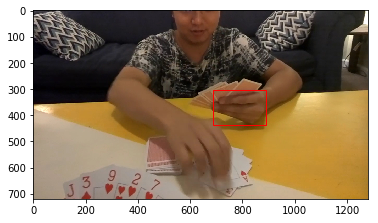

In [4]:
fig, ax = plt.subplots(1)
ax.imshow(plt.imread('./data/Hand/images/CARDS_LIVINGROOM_B_T_frame_1366.jpg'))
ax.add_patch(patches.Rectangle((686, 305), 889 - 686, 436 - 305, linewidth = 1, edgecolor = 'r', facecolor = 'none'))
plt.show()

In [0]:
def get_hand_dicts(image_dir, dataframe):
    unique_files = list(np.unique(np.array(list(dataframe['filename']))))
    dataset_dicts = []
    for file in tqdm_notebook(unique_files):
        df = dataframe[dataframe.filename == file]
        objs = []
        record = {}
        file_name = os.path.join(image_dir, file)
        height, width = 0, 0
        for index, row in df.iterrows():
            x_min = row['xmin']
            x_max = row['xmax']
            y_min = row['ymin']
            y_max = row['ymax']
            height = row['height']
            width = row['width']
            obj = {
                "bbox": [x_min, y_min, x_max, y_max],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record['file_name'] = file_name
        record['height'] = height
        record['width'] = width
        record['annotations'] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [6]:
# Register Hand Dataset
for d in ["train", "val"]:
    if d == 'train':
        DatasetCatalog.register("hand/" + d, lambda d = d: get_hand_dicts('./data/Hand/images', train_labels))
    else:
        DatasetCatalog.register("hand/" + d, lambda d = d: get_hand_dicts('./data/Hand/images', test_labels))
    MetadataCatalog.get("hand/" + d).set(thing_classes = ["hand"])
hand_metadata = MetadataCatalog.get("hand/train")
hand_metadata

Metadata(name='hand/train', thing_classes=['hand'])

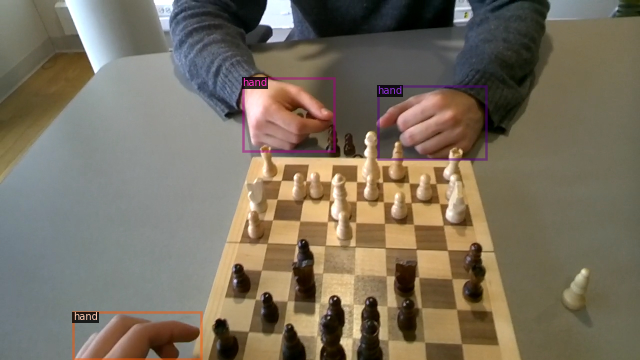

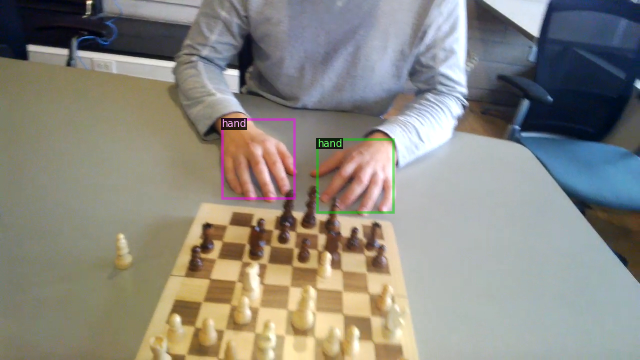

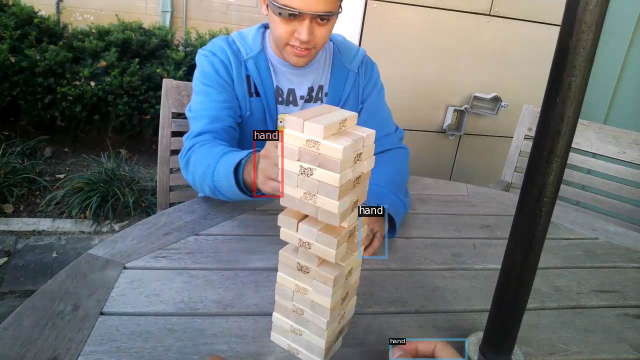

In [7]:
# Visualize Dataset
dataset_dicts = get_hand_dicts('./data/Hand/images', train_labels)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata = hand_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [8]:
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
cfg.DATASETS.TRAIN = ("hand/train",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_C4_3x/137849393/model_final_f97cb7.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 400    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

WARNING [10/11 13:45:08 d2.config.compat]: Config './detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_C4_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [9]:
# Trainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume = False)

[10/11 13:45:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 


[10/11 13:45:26 d2.data.build]: Removed 0 images with no usable annotations. 4383 images left.
[10/11 13:45:27 d2.data.build]: Distribution of training instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    hand    | 13647        |
|            |              |
[10/11 13:45:27 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/11 13:45:27 d2.data.build]: Using training sampler TrainingSampler


'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (2, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (4, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.


In [10]:
trainer.train()

[10/11 13:45:33 d2.engine.train_loop]: Starting training from iteration 0
[10/11 13:46:00 d2.utils.events]: eta: 0:08:37  iter: 19  total_loss: 1.775  loss_cls: 0.623  loss_box_reg: 0.799  loss_rpn_cls: 0.284  loss_rpn_loc: 0.033  time: 1.3651  data_time: 0.0040  lr: 0.000050  max_mem: 2070M
[10/11 13:46:28 d2.utils.events]: eta: 0:08:13  iter: 39  total_loss: 1.655  loss_cls: 0.513  loss_box_reg: 0.888  loss_rpn_cls: 0.233  loss_rpn_loc: 0.038  time: 1.3784  data_time: 0.0042  lr: 0.000100  max_mem: 2070M
[10/11 13:46:56 d2.utils.events]: eta: 0:07:59  iter: 59  total_loss: 1.527  loss_cls: 0.418  loss_box_reg: 0.929  loss_rpn_cls: 0.150  loss_rpn_loc: 0.032  time: 1.3924  data_time: 0.0039  lr: 0.000150  max_mem: 2070M
[10/11 13:47:24 d2.utils.events]: eta: 0:07:26  iter: 79  total_loss: 1.342  loss_cls: 0.292  loss_box_reg: 0.914  loss_rpn_cls: 0.090  loss_rpn_loc: 0.025  time: 1.3889  data_time: 0.0043  lr: 0.000200  max_mem: 2070M
[10/11 13:47:52 d2.utils.events]: eta: 0:07:03  it

OrderedDict()

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("hand_val", )
predictor = DefaultPredictor(cfg)

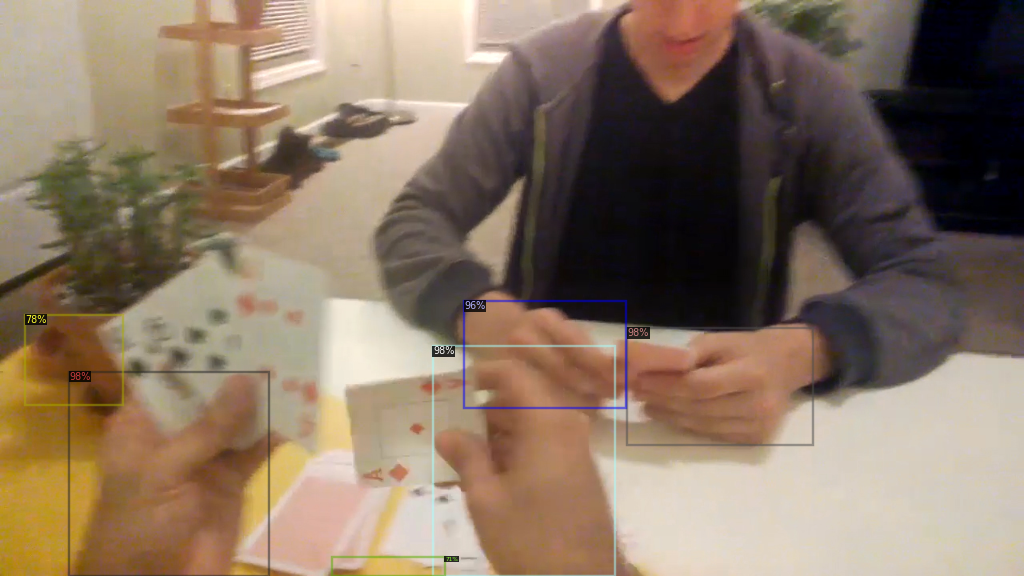

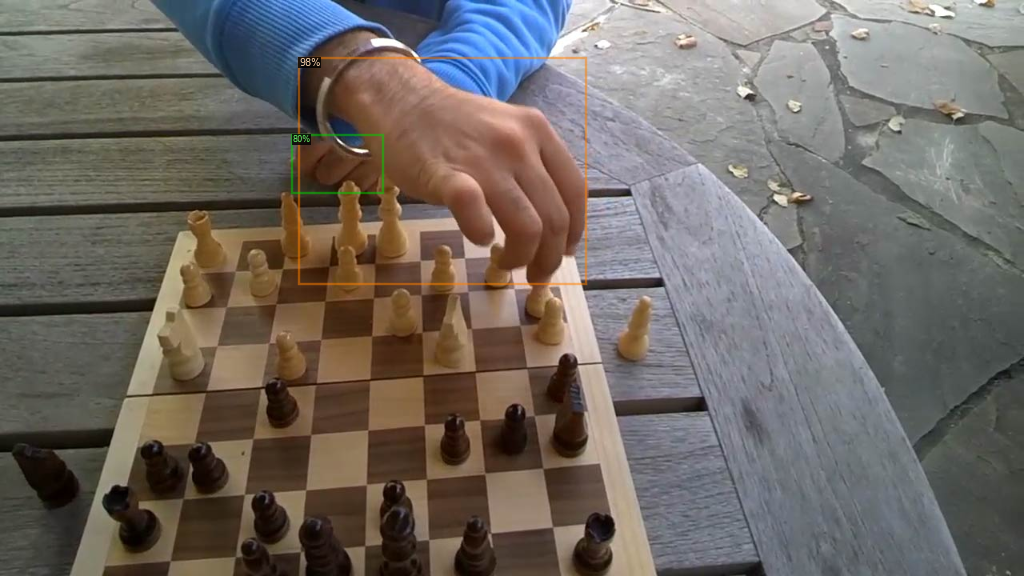

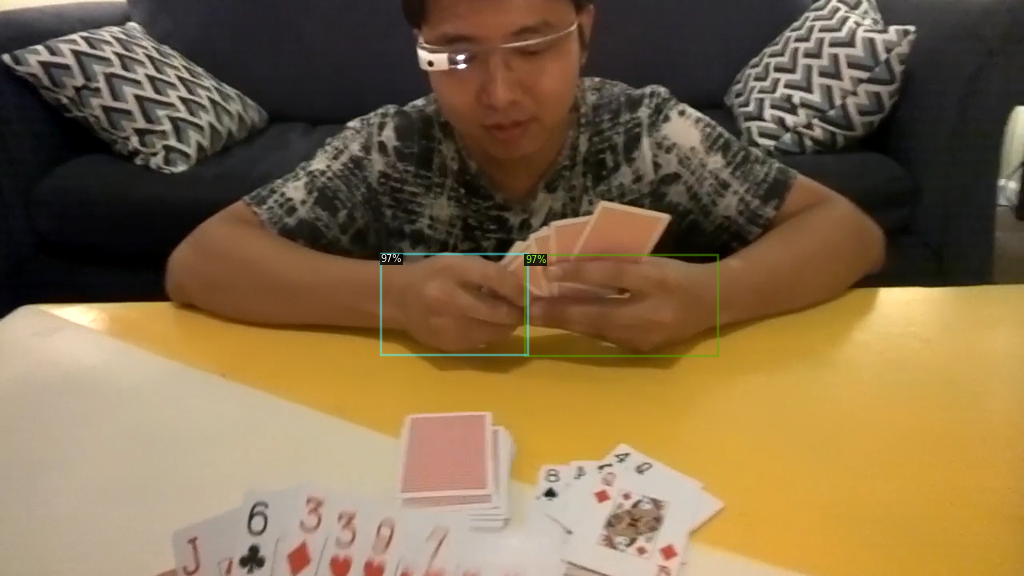

In [12]:
# Inference on Validation Set

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_hand_dicts('./data/Hand/images', test_labels)
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    # print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("hand_val"), 
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])